In [1]:
from clawpack import pyclaw
import numpy  as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML
from __future__ import absolute_import
from clawpack import riemann
#from clawpack.riemann.shallow_roe_with_efix_1D_constants import depth, momentum, num_eqn

In [2]:
def sigmoid(x):
    p = np.multiply(-1,x)
    vals = 1/(1+np.power(np.e,p))
    return vals
sigmoid([0,1,2])

array([ 0.5       ,  0.73105858,  0.88079708])

In [3]:
def entropycalc(h,u,num_ghost):
    #pass in h-b to adjust for topography
    # I think I need to pass from custom bc
    #ghost = h[:num_ghost] + h[-num_ghost:]
    #ughost = u[:num_ghost] + u[-num_ghost:]#remove BC values
    hfixed = h[num_ghost:-num_ghost]
    ufixed = u[num_ghost:-num_ghost] # Removing the ghost cells
    currentEntropyArray =  np.add( hfixed,np.multiply(ufixed,ufixed) ) #- hghost - ughost
    summedE = np.sum(currentEntropyArray)
    global entropies
    global fullE
    fullE = fullE + [currentEntropyArray]
    entropies = entropies + [summedE]
    #look at two different states and subtract for flux?
    
    #fornberg algorithm for finite differences method take coeffs from result. might be in matlab
    # banks fornberg

In [4]:
 def custom_bc(state,dim,t,qbc,num_ghost):
    qbc[0,0] = in_height
    qbc[0,1] = in_height
    qbc[-1,0] = 0
    qbc[-2,0] = 0
    
    #qbc[0,:num_ghost] = qbc[]

    qbc[1,0] = in_velocity
    qbc[1,1] = in_velocity
    qbc[1,-1] = qbc[1,-3]
    qbc[1,-2] = qbc[1,-3]
    entropycalc(qbc[0,:],qbc[1,:],num_ghost)

In [17]:
def runclaw(in_height,in_velocity,xlower,xupper):
    claw = pyclaw.Controller()
    claw.tfinal = 500.0
    claw.keep_copy = True
    claw.output_format = None
    claw.num_output_times = 100
    #rs = riemann.shallow_roe_with_efix_1D
    rs = riemann.shallow_1D_py.shallow_fwave_1d

    num_eqn = 2
    solver = pyclaw.ClawSolver1D(rs)
    solver.order = 2
    solver.num_ghost = 2
    solver.num_waves=2
    solver.num_eqn=2
    #solver.limiters = pyclaw.limiters.tvd.minmod
    #solver.limiters = pyclaw.limiters.tvd.vanleer

    solver.kernel_language = 'Python'

    #solver.all_bcs = pyclaw.BC.periodic
    solver.bc_upper[0] = pyclaw.BC.extrap
    solver.bc_lower[0] = pyclaw.BC.custom
    #solver.bc_upper[0] = pyclaw.BC.custom
    solver.user_bc_lower = custom_bc

    #print(solver.bc_lower)
    solver.aux_bc_lower[0] = pyclaw.BC.extrap
    solver.aux_bc_upper[0] = pyclaw.BC.extrap


    #solver.all_bcs = pyclaw.BC.periodic

    #xlower = -2.0
    #xupper = 50.0
    mx = 800
    x = pyclaw.Dimension(xlower,xupper,mx,name='x')
    domain = pyclaw.Domain(x)
    state = pyclaw.State(domain,num_eqn,1)

    state.problem_data['grav'] = 1.0
    state.problem_data['sea_level'] = 0.0
    state.problem_data['dry_tolerance'] = 0.1

    xc = state.grid.x.centers
    x0=0.0


    #state.q[0,:] = hl * (xc <= x0) + hr * (xc > x0) #+ hc*(x0-obj_size < xc)*(xc < x0+obj_size )
    #state.q[0,:] = 3
    state.q[0,:] = in_height# - ((in_height/1.5)*(xc>=x0+10))  #+(1 * (xc<x0)+ (1 - xc/1) * (xc>= x0) * (xc < 1) )
    #state.q[0,:] =  in_height + (0.5 * (xc<x0)+ (0.5 - xc/10) * (xc>= x0) * (xc < 5)) -0.5
    state.q[1,:] = in_velocity + 0.5*(xc>= x0) - 0.25*(xc>= x0+15)   #ul * (xc <= x0) + ur * (xc > x0)

    #state.aux[0, :] = 1.0 * np.exp(-xc**2 / 0.2**2) - 1.0
    #state.aux[0,:] = sigmoid(np.multiply(-1,xc))/4

    state.aux[0, :] = 0.5 * (xc<x0)+ (0.5 - xc/10) * (xc>= x0) * (xc < 5) #low slope IC
    #state.aux[0, :] = 1 * (xc<x0)+ (1 - xc/10) * (xc>= x0) * (xc < 10) #higher slope IC
    #state.aux[0,:] = 0.5* (xc<x0)  #step IC

    #state.aux[0,:] = 0

    #state.q[0,:] = hl * (xc <= x0 - obj_size) + hr * (xc > x0+obj_size) + hc*(x0-obj_size < xc)*(xc < x0+obj_size )
    #state.q[1,:] = hl*ul * (xc <= x0) + hr*ur * (xc > x0)

    plt.plot(xc,state.q[0,:])
    plt.plot(xc,state.aux[0,:])
    plt.plot(xc,state.q[1,:])

    claw.solution = pyclaw.Solution(state,domain)
    claw.solver = solver
    claw.run()
    return [claw.frames,xc]

In [18]:
#plt.plot(xc,state.q[0,:])
#plt.plot(xc,state.aux[0,:])
#plt.plot(xc,state.q[1,:])

In [19]:
#claw.solution = pyclaw.Solution(state,domain)
#claw.solver = solver
#claw.run()

2019-02-19 14:44:17,971 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-02-19 14:44:17,977 INFO CLAW: Solution 0 computed for time t=0.000000


/home/max/anaconda3/lib/python3.6/site-packages/clawpack/riemann/shallow_1D_py.py:206: RuntimeWarning: divide by zero encountered in true_divide
  q_l[1,:] / q_l[0,:], 0.0)


2019-02-19 14:44:18,315 INFO CLAW: Solution 1 computed for time t=5.000000
2019-02-19 14:44:18,632 INFO CLAW: Solution 2 computed for time t=10.000000
2019-02-19 14:44:18,971 INFO CLAW: Solution 3 computed for time t=15.000000
2019-02-19 14:44:19,325 INFO CLAW: Solution 4 computed for time t=20.000000
2019-02-19 14:44:19,681 INFO CLAW: Solution 5 computed for time t=25.000000
2019-02-19 14:44:20,041 INFO CLAW: Solution 6 computed for time t=30.000000
2019-02-19 14:44:20,453 INFO CLAW: Solution 7 computed for time t=35.000000
2019-02-19 14:44:20,878 INFO CLAW: Solution 8 computed for time t=40.000000
2019-02-19 14:44:21,276 INFO CLAW: Solution 9 computed for time t=45.000000
2019-02-19 14:44:21,708 INFO CLAW: Solution 10 computed for time t=50.000000
2019-02-19 14:44:22,161 INFO CLAW: Solution 11 computed for time t=55.000000
2019-02-19 14:44:22,598 INFO CLAW: Solution 12 computed for time t=60.000000
2019-02-19 14:44:22,977 INFO CLAW: Solution 13 computed for time t=65.000000
2019-02-1

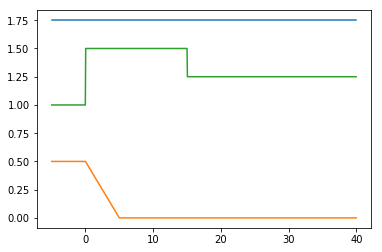

In [20]:
#from clawpack.visclaw import ianimate
#ianimate.ianimate(claw)

#testframe = claw.frames[50]
#testframe2 = claw.frames[1]
#np.mean(testframe.q[0,:]-testframe2.q[0,:])
in_height = 1.75
in_velocity = 1
xlower = -5
xupper = 40
entropies = []
fullE = []
solns,xc = runclaw(in_height, in_velocity, xlower, xupper)

In [21]:
#in_height = 1.75
#in_velocity = 2
#solns = runclaw(in_height, in_velocity)
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

frame = solns[0]
depth = frame.q[0,:]
line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
line3, = ax.plot([], [], lw=2)
plt.legend(['Fluid height','Fluid velocity', 'Topography'])
plt.xlabel('X')
plt.ylabel('h, u, b')
ax.set_xlim(xlower,xupper)
ax.set_ylim(-5,5)
def fplot(frame_number):
    frame = solns[frame_number]
    depth = frame.q[0,:]
    velocity = frame.q[1,:]
    b = frame.aux[0,:]
    line1.set_data(xc,depth)
    line2.set_data(xc,velocity)
    line3.set_data(xc,b)
    return line1,

anim = animation.FuncAnimation(fig, fplot, frames=len(solns), interval=50, repeat=False) #len(claw.frames) can be put in frames=
plt.close()
HTML(anim.to_jshtml())

In [10]:
test = solns[15]
test.q[0,:]

array([ 1.19319144,  1.19015846,  1.18778278,  1.1854049 ,  1.18302334,
        1.18063768,  1.17824746,  1.1758521 ,  1.17345091,  1.17104304,
        1.16862743,  1.16620272,  1.16376715,  1.16131837,  1.15885314,
        1.15636682,  1.15385244,  1.15129871,  1.14868554,  1.14597083,
        1.14303466,  1.13818334,  1.07170466,  1.00222824,  0.96187118,
        0.93141038,  0.90642916,  0.88504226,  0.86623825,  0.84940059,
        0.83412102,  0.82011292,  0.80716612,  0.79512119,  0.78385388,
        0.77326521,  0.76327485,  0.75381658,  0.74483508,  0.7362836 ,
        0.72812223,  0.72031657,  0.71283678,  0.70565689,  1.28114407,
        1.73597754,  1.73604118,  1.73611436,  1.73618819,  1.73626018,
        1.73632977,  1.73639677,  1.73646107,  1.73652268,  1.73658102,
        1.73663607,  1.73668787,  1.73673647,  1.73678191,  1.73682412,
        1.73686321,  1.73689929,  1.73693248,  1.73696296,  1.73699084,
        1.73701628,  1.7370395 ,  1.73706065,  1.73707991,  1.73

In [11]:
xc

array([ -4.8875,  -4.6625,  -4.4375,  -4.2125,  -3.9875,  -3.7625,
        -3.5375,  -3.3125,  -3.0875,  -2.8625,  -2.6375,  -2.4125,
        -2.1875,  -1.9625,  -1.7375,  -1.5125,  -1.2875,  -1.0625,
        -0.8375,  -0.6125,  -0.3875,  -0.1625,   0.0625,   0.2875,
         0.5125,   0.7375,   0.9625,   1.1875,   1.4125,   1.6375,
         1.8625,   2.0875,   2.3125,   2.5375,   2.7625,   2.9875,
         3.2125,   3.4375,   3.6625,   3.8875,   4.1125,   4.3375,
         4.5625,   4.7875,   5.0125,   5.2375,   5.4625,   5.6875,
         5.9125,   6.1375,   6.3625,   6.5875,   6.8125,   7.0375,
         7.2625,   7.4875,   7.7125,   7.9375,   8.1625,   8.3875,
         8.6125,   8.8375,   9.0625,   9.2875,   9.5125,   9.7375,
         9.9625,  10.1875,  10.4125,  10.6375,  10.8625,  11.0875,
        11.3125,  11.5375,  11.7625,  11.9875,  12.2125,  12.4375,
        12.6625,  12.8875,  13.1125,  13.3375,  13.5625,  13.7875,
        14.0125,  14.2375,  14.4625,  14.6875,  14.9125,  15.1

In [23]:
entropies[-5:-1]

[2431.5488731916221,
 2431.5488680766048,
 2431.5488629625002,
 2431.5488578493196]

In [16]:
fullE[50]

array([ 2.75257002,  2.75431   ,  2.75662734,  2.75969436,  2.76357622,
        2.76826965,  2.7737048 ,  2.77974865,  2.78621494,  2.79287691,
        2.79948459,  2.80578108,  2.81153359,  2.81651233,  2.82048666,
        2.82325458,  2.82463563,  2.82444825,  2.82245271,  2.81823428,
        2.8109364 ,  2.79843131,  2.79403253,  2.83171295,  2.87001231,
        2.90877731,  2.94800389,  2.98769102,  3.02784669,  3.06848276,
        3.1096234 ,  3.15131063,  3.19362319,  3.23672042,  3.28092024,
        3.32673899,  3.374942  ,  3.42621526,  3.48027769,  3.53502189,
        3.58739163,  3.63559735,  3.67993404,  3.72140617,  3.75869784,
        3.75964758,  3.76063046,  3.76158543,  3.76252661,  3.76346503,
        3.76443933,  3.76544445,  3.76641778,  3.76744148,  3.76848574,
        3.76939175,  3.7702106 ,  3.77099568,  3.77177303,  3.7725543 ,
        3.77359414,  3.77962523,  3.83715726,  4.12630198,  4.65317326,
        4.95797975,  5.11002304,  5.16875495,  5.18323428,  5.17